<a href="https://colab.research.google.com/github/bugrakaann/SuspiciousActionRecognition/blob/master/x3dxs_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install pytorchvideo torchvision
!pip install pytorchvideo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 59.7 MB/s eta 0:00:00
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188686 sha256=8a902da7c91b511f1eb4f0d12d31c2a70705f8911635983636d960c7d8ee4b3d
  Stored in directory: /root/.cache/pip/wheels/a4/6d/ae/d016375a73be141a0e11bb42289e2d0b046c35687fc8010ecc
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=64ab163d7ef361d488353970a0f20d8dd690a01556e129041531ddfbd1cdc1d6
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel f

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [ ]:
import zipfile

output_path = '/content/drive/MyDrive/dataset.zip'

# Dosyayı unzip yap
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

print("Dosya başarıyla indirildi ve çıkarıldı.")

Dosya başarıyla indirildi ve çıkarıldı.


In [ ]:
import os
import pandas as pd

# 🔥 Ana dataset klasörü
dataset_path = "/content/sample_data/dataset/Videos/Videos/"

# 📌 Normal ve Abnormal klasörlerini al
normal_path = os.path.normpath(os.path.join(dataset_path, "normal"))
abnormal_path = os.path.normpath(os.path.join(dataset_path, "abnormal"))

# 📌 Tüm abnormal sınıfları al
abnormal_classes = [folder for folder in os.listdir(abnormal_path) if os.path.isdir(os.path.join(abnormal_path, folder))]
class_to_index = {cls: idx for idx, cls in enumerate(abnormal_classes, start=1)}  # 1, 2, 3... (Abnormal sınıflar)

# 📌 DataFrame oluşturmak için liste
data = []

# ✅ Normal videolar (Binary = 0, Multi = -1)
for subfolder in os.listdir(normal_path):
    subfolder_path = os.path.normpath(os.path.join(normal_path, subfolder))

    if os.path.isdir(subfolder_path):  # Eğer bir klasörse
        videos = [
            os.path.normpath(os.path.join(subfolder_path, v)).replace("\\", "/")  # Windows uyumu için düzeltilmiş
            for v in os.listdir(subfolder_path) if v.endswith(('.mp4', '.avi', '.mov'))
        ]
        for video in videos:
            data.append((video, "normal", 0, -1))  # Binary label = 0, Multi label = -1 (yok)

# ✅ Anormal videolar (Binary = 1, Multi = class index)
for subfolder in abnormal_classes:
    subfolder_path = os.path.normpath(os.path.join(abnormal_path, subfolder))

    if os.path.isdir(subfolder_path):
        # Rekürsif olarak tüm alt klasörleri gezer
        for root, dirs, files in os.walk(subfolder_path):
            for file in files:
                if file.endswith(('.mp4', '.avi', '.mov')):
                    video_path = os.path.normpath(os.path.join(root, file)).replace("\\", "/")
                    # Burada 'subfolder' en üst düzey klasör adını temsil eder;
                    # eğer alt klasörlere göre farklı etiket atamak isterseniz, root veya dosya adını parse edebilirsiniz.
                    data.append((video_path, subfolder, 1, class_to_index.get(subfolder, -1)))

# 🔥 DataFrame oluştur
df = pd.DataFrame(data, columns=["video_path", "category", "binary_label", "multi_label"])


In [ ]:
#Balanced dataframe
import pandas as pd

# 1) Normal ve Anormal df’lerini ayır
normal_df = df[df.binary_label == 0]
anorm_df  = df[df.binary_label == 1]

# 2) Sabit undersample sayısı (istediğin kadar değiştir)
n_per_abnormal = 400

# 3) Stratified undersample: her multi_label’dan n_per_abnormal örnek çek
anorm_strat = (
    anorm_df
    .groupby('multi_label', group_keys=False)
    .apply(lambda grp: grp.sample(n=n_per_abnormal, random_state=42))
)

# 4) Toplam anormal; normal’dan oversample ile kapatılacak fark
total_anormal = len(anorm_strat)
current_normal = len(normal_df)
to_add = total_anormal - current_normal

if to_add > 0:
    # 5) Normal’dan replace=True ile oversample
    normal_oversampled = normal_df.sample(
        n=to_add,
        replace=True,
        random_state=42
    ).copy()
    # augment flag’i (data pipeline’da augmentation için kullan)
    normal_oversampled['augment'] = True
else:
    normal_oversampled = pd.DataFrame(columns=normal_df.columns.tolist()+['augment'])

# 6) Orijinal normal’lara da augment=False ekle
normal_df = normal_df.copy()
normal_df['augment'] = False

# 7) Final balanced dataframe
balanced_df = pd.concat([anorm_strat, normal_df, normal_oversampled]) \
                .sample(frac=1, random_state=42)

# Kontrol
print("Binary dağılım:\n", balanced_df.binary_label.value_counts())
print("Multi-class (anormal) dağılım:\n", balanced_df.multi_label.value_counts())
print("Normal augment edilmesi gereken:", normal_oversampled.shape[0])


Binary dağılım:
 binary_label
0    1200
1    1200
Name: count, dtype: int64
Multi-class (anormal) dağılım:
 multi_label
-1    1200
 3     400
 1     400
 2     400
Name: count, dtype: int64
Normal augment edilmesi gereken: 354


<ipython-input-6-eda4264191be>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(n=n_per_abnormal, random_state=42))


In [ ]:
train_df, test_df = train_test_split(balanced_df, test_size=0.2,stratify=balanced_df["binary_label"],random_state=42)

print(f"Train set {len(train_df)} videos")
print(f"Test set {len(test_df)} videos")

Train set 1920 videos
Test set 480 videos


<ipython-input-8-1f8d38166389>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(subclass_counts.index, rotation=45, ha='right')


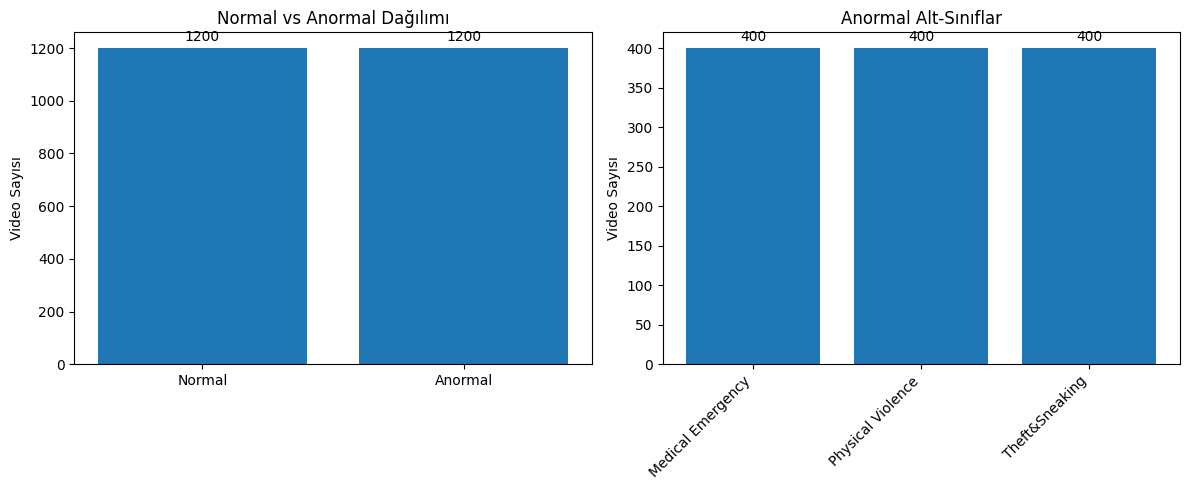

In [ ]:
import matplotlib.pyplot as plt

# 1) Binary dağılım: normal vs anormal
binary_counts = balanced_df['binary_label'].value_counts().rename({0: 'Normal', 1: 'Anormal'})

# 2) Anormal alt-sınıf dağılımı
abnormal_df     = balanced_df[balanced_df['binary_label'] == 1]
subclass_counts = abnormal_df['category'].value_counts()

# 3) Çift grafikli figür oluştur
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Sol: Normal vs Anormal ---
bars1 = axes[0].bar(binary_counts.index, binary_counts.values)
axes[0].set_title('Normal vs Anormal Dağılımı')
axes[0].set_ylabel('Video Sayısı')
for tick in axes[0].get_xticklabels():
    tick.set_rotation(0)

# --- Sağ: Anormal Alt-Sınıf Dağılımı ---
bars2 = axes[1].bar(subclass_counts.index, subclass_counts.values)
axes[1].set_title('Anormal Alt-Sınıflar')
axes[1].set_ylabel('Video Sayısı')
axes[1].set_xticklabels(subclass_counts.index, rotation=45, ha='right')

# 4) Bar üzerine değer ekleme

# Yöntem A: matplotlib ≥3.4 ise bar_label kullanabilirsiniz
axes[0].bar_label(bars1, labels=binary_counts.values, padding=3, fontsize=10)
axes[1].bar_label(bars2, labels=subclass_counts.values, padding=3, fontsize=10)


plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf

# GPU kullanımını kontrol et
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPU bulunuyor:", physical_devices)
else:
    print("GPU bulunamadı.")


GPU bulunuyor: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

import cv2
import numpy as np
import torch

def frame_stream(path, target_size, frame_interval):
    """
    Video’dan:
      • her frame_interval.frame’ı al,
      • target_size’a (W, H) resize et,
      • BGR→RGB çevir,
      • [0,1] aralığına normalize edip
      • HWC formatında yield et.
    """
    cap = cv2.VideoCapture(path)
    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx % frame_interval == 0:
            # Resize
            frame_resized = cv2.resize(frame, target_size)
            # BGR→RGB
            frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
            # Normalize
            yield frame_rgb.astype(np.float32) / 255.0
        idx += 1
    cap.release()

In [ ]:
import torchvision.transforms as T

#Augmentation

def frame_dropout(frames, p=0.2):
    """Belirli bir ihtimalle rastgele kareleri düşür."""
    keep_mask = torch.rand(len(frames)) > p
    return frames[keep_mask] if keep_mask.sum() > 0 else frames

def speed_perturbation(frames, min_speed=0.8, max_speed=1.2):
    """Videoyu rastgele hızlandır veya yavaşlat."""
    speed_factor = torch.FloatTensor(1).uniform_(min_speed, max_speed).item()
    indices = torch.linspace(0, len(frames)-1, int(len(frames) * speed_factor)).long()
    return frames[indices]

#Fixes frame count after applying frame dropout at augmentation

def fix_frame_count(frames: torch.Tensor, target_num_frames: int) -> torch.Tensor:
    """
    Frame sayısını sabitler:
     - Eğer fazla ise kırpar,
     - Eğer eksikse son frame’i tekrarlar,
     - Eğer hiç frame yoksa sıfırlardan bir clip döner.
    """
    # frames: (T, C, H, W)
    T, C, H, W = frames.shape

    # 1) Eğer hiç frame yoksa sıfırdan bir clip oluştur
    if T == 0:
        return torch.zeros((target_num_frames, C, H, W),
                           dtype=frames.dtype,
                           device=frames.device)

    # 2) Fazla varsa kırp
    if T > target_num_frames:
        return frames[:target_num_frames]

    # 3) Eksikse son frame’i tekrar et
    if T < target_num_frames:
        repeat_count = target_num_frames - T
        last = frames[-1].unsqueeze(0).repeat(repeat_count, 1, 1, 1)
        return torch.cat([frames, last], dim=0)

    # 4) Tamamsa olduğu gibi döndür
    return frames


frame_transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=(-10, 10)),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    T.RandomApply([T.GaussianBlur(3)], p=0.3),
    T.RandomApply([T.RandomGrayscale(p=0.2)], p=0.2),
])

Resuming from checkpoint: /content/drive/MyDrive/modelepochsaves/conv3d_ae_saves/ae_epoch_50.h5


<ipython-input-8-6328bd936ff9>:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(last_ckpt)


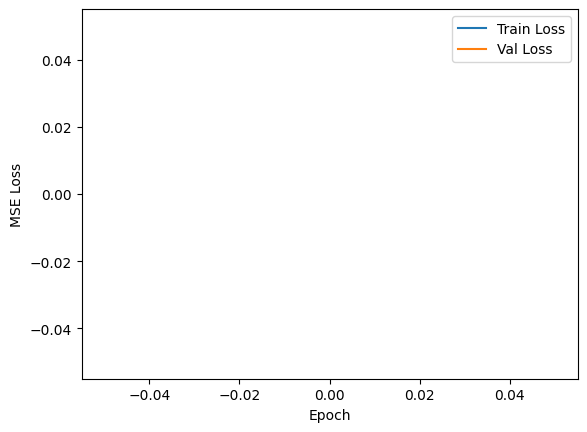

In [ ]:
import os
import glob
import datetime
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Helper Functions --------------------------------------------------------
def frame_stream(path, target_size, frame_interval):
    cap = cv2.VideoCapture(path)
    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx % frame_interval == 0:
            resized = cv2.resize(frame, target_size)
            rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
            yield rgb.astype(np.float32) / 255.0
        idx += 1
    cap.release()

def fix_frame_count(frames, target_num_frames):
    T, C, H, W = frames.shape
    if T == 0:
        return torch.zeros((target_num_frames, C, H, W), dtype=frames.dtype, device=frames.device)
    if T > target_num_frames:
        return frames[:target_num_frames]
    if T < target_num_frames:
        last = frames[-1:].repeat(target_num_frames - T, 1, 1, 1)
        return torch.cat([frames, last], dim=0)
    return frames

# --- Dataset --------------------------------------------------------
class AEDataset(Dataset):
    def __init__(self, metadata_df, num_frames=16, resize_size=(128,128), frame_interval=10):
        self.meta = metadata_df.reset_index(drop=True)
        self.num_frames = num_frames
        self.resize_size = resize_size
        self.frame_interval = frame_interval

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        frames = list(frame_stream(row.video_path, self.resize_size, self.frame_interval))
        frames = [torch.from_numpy(f).permute(2, 0, 1) for f in frames]  # (C, H, W)
        clip = torch.stack(frames, dim=1)  # (C, T, H, W)
        clip = fix_frame_count(clip.permute(1,0,2,3), self.num_frames).permute(1,0,2,3)  # back to (C,T,H,W)
        return clip, clip

# --- Data Preparation ------------------------------------------------
ae_train_df = balanced_df[balanced_df['binary_label'] == 0].copy()
train_df, val_df = train_test_split(ae_train_df, test_size=0.2, random_state=42)

batch_size = 8
train_loader = DataLoader(AEDataset(train_df), batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(AEDataset(val_df), batch_size=batch_size, shuffle=False, num_workers=4)

# --- 3D Conv Autoencoder ------------------------------------------------------
class Conv3DAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm3d(32),
            nn.Conv3d(32, 64, kernel_size=3, stride=(1,2,2), padding=1), nn.ReLU(), nn.BatchNorm3d(64),
            nn.Conv3d(64, 128, kernel_size=3, stride=(1,2,2), padding=1), nn.ReLU(), nn.BatchNorm3d(128)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=(1,2,2), padding=1, output_padding=(0,1,1)), nn.ReLU(), nn.BatchNorm3d(64),
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=(1,2,2), padding=1, output_padding=(0,1,1)), nn.ReLU(), nn.BatchNorm3d(32),
            nn.Conv3d(32, 3, kernel_size=3, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# --- Training Setup ----------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Conv3DAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=3, min_lr=1e-6)

ckpt_dir = '/content/drive/MyDrive/modelepochsaves/conv3d_ae_saves'
os.makedirs(ckpt_dir, exist_ok=True)

ckpt_files = glob.glob(os.path.join(ckpt_dir, 'ae_epoch_*.h5'))
if ckpt_files:
    last_ckpt = sorted(ckpt_files)[-1]
    print(f"Resuming from checkpoint: {last_ckpt}")
    ckpt = torch.load(last_ckpt)
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt['optim_state'])
    start_epoch = ckpt['epoch'] + 1
    best_val_loss = ckpt.get('best_val_loss', float('inf'))
else:
    start_epoch = 1
    best_val_loss = float('inf')

# --- Training Loop -----------------------------------------------------------
epochs = 50
train_losses, val_losses = [], []
for epoch in range(start_epoch, epochs + 1):
    model.train()
    run_train = 0.0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon = model(x)
        recon = recon[:, :, :x.size(2)]  # Fix time dim mismatch if needed
        loss = criterion(recon, x)
        loss.backward()
        optimizer.step()
        run_train += loss.item() * x.size(0)
    tl = run_train / len(train_loader.dataset)
    train_losses.append(tl)

    model.eval()
    run_val = 0.0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device)
            recon = model(x)
            recon = recon[:, :, :x.size(2)]
            run_val += criterion(recon, x).item() * x.size(0)
    vl = run_val / len(val_loader.dataset)
    val_losses.append(vl)

    print(f"Epoch {epoch}/{epochs} — train_loss: {tl:.4f}, val_loss: {vl:.4f}")
    scheduler.step(vl)

    # Save checkpoint
    ckpt_path = os.path.join(ckpt_dir, f'ae_epoch_{epoch:02d}.h5')
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optim_state': optimizer.state_dict(),
        'best_val_loss': best_val_loss
    }, ckpt_path)

    if vl < best_val_loss:
        best_val_loss = vl
        print(f"New best val loss: {best_val_loss:.4f}")

# --- Plot Losses ------------------------------------------------------------
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm

# --- Conv3D Autoencoder Tanımı (eğittiğinle birebir aynı) ---
class Conv3DAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm3d(32),
            nn.Conv3d(32, 64, 3, stride=(1,2,2), padding=1), nn.ReLU(), nn.BatchNorm3d(64),
            nn.Conv3d(64,128, 3, stride=(1,2,2), padding=1), nn.ReLU(), nn.BatchNorm3d(128),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(128,64, 3, stride=(1,2,2), padding=1, output_padding=(0,1,1)), nn.ReLU(), nn.BatchNorm3d(64),
            nn.ConvTranspose3d(64, 32, 3, stride=(1,2,2), padding=1, output_padding=(0,1,1)), nn.ReLU(), nn.BatchNorm3d(32),
            nn.Conv3d(32, 3, 3, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# --- Frame akış fonksiyonu ---
def frame_stream(video_path, target_size, frame_interval):
    cap = cv2.VideoCapture(video_path)
    idx, buf = 0, []
    while True:
        ret, frame = cap.read()
        if not ret: break
        if idx % frame_interval == 0:
            f = cv2.resize(frame, target_size)
            f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
            buf.append(f.astype(np.float32)/255.0)
        idx += 1
    cap.release()
    return buf

# --- Ayarlar ---
model_path      = "/content/drive/MyDrive/modelepochsaves/conv3d_ae_saves/ae_epoch_50.h5"
video_dir       = "/content/sample_data/dataset/Videos/Videos"
output_csv      = "/content/drive/MyDrive/modelepochsaves/autoencoder_features3d_batched.csv"
target_size     = (128, 128)
frame_interval  = 10
clip_len        = 16
batch_clips     = 16  # kaç clip’i bir batch’te işleyeceğiz
device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Modeli yükle ---
model = Conv3DAutoencoder().to(device)
ckpt   = torch.load(model_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.eval()

# CSV başlığı
first_write = True

# Tüm videoları bul
video_files = [
    os.path.join(r, f)
    for r,_,fs in os.walk(video_dir)
    for f in fs if f.lower().endswith(('.mp4','.avi','.mov'))
]

with torch.no_grad():
    for vid_id, vid_path in enumerate(tqdm(video_files, desc="Videolar")):
        frames = frame_stream(vid_path, target_size, frame_interval)
        n_clips = len(frames) - clip_len + 1

        clip_buffer = []
        meta_buffer = []

        for start in range(n_clips):
            clip = frames[start:start+clip_len]  # list of (H,W,C)
            # (T, H, W, C) → (C, T, H, W)
            clip_tensor = torch.stack([
                torch.from_numpy(f).permute(2,0,1) for f in clip
            ], dim=1).unsqueeze(0).to(device)  # shape (1, C, T, H, W)

            clip_buffer.append(clip_tensor)
            meta_buffer.append((vid_id, vid_path))

            # eğer buffer tam dolduysa ya da son clipe geldiysek batch işle
            if len(clip_buffer) == batch_clips or start == n_clips-1:
                batch = torch.cat(clip_buffer, dim=0)  # (B, C, T, H, W)
                encoded = model.encoder(batch)         # (B, 128, T', H', W')
                recon   = model.decoder(encoded)       # (B, 3, T, H, W)

                # Öznitelik ve hata hesapla
                feats  = encoded.mean(dim=[2,3,4]).cpu().numpy()  # (B, 128)
                errors = ((batch - recon)**2).mean(dim=[1,2,3,4]).cpu().numpy()  # (B,)

                # DataFrame oluşturup CSV'ye ekle
                rows = []
                for i in range(len(feats)):
                    row = {f"feat_{j}": feats[i,j] for j in range(feats.shape[1])}
                    row["recon_error"] = errors[i]
                    row["video_id"]    = meta_buffer[i][0]
                    row["video_path"]  = meta_buffer[i][1]
                    rows.append(row)

                df = pd.DataFrame(rows)
                df.to_csv(output_csv,
                          mode='w' if first_write else 'a',
                          header=first_write,
                          index=False)
                first_write = False

                # buffer'ı temizle
                clip_buffer.clear()
                meta_buffer.clear()

        # Bellek temizliği
        gc.collect()

print("✅ Batched özellik çıkarımı tamamlandı:", output_csv)


<ipython-input-9-0d68d791d83d>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt   = torch.load(model_path, map_location=device)
Videolar: 100%|██████████| 3304/3304 [3

✅ Batched özellik çıkarımı tamamlandı: /content/drive/MyDrive/modelepochsaves/autoencoder_features3d_batched.csv


In [ ]:
# 1) Checkpoint’ten önce bir weight snapshot alıp ekrana basın
#    (bunu load etmeden önce, model’in initialize edilmiş halini ilk çalıştırdığınızda yapabilirsiniz)
# print("Önce:", next(model.encoder.parameters()).mean().item(),
#               next(model.encoder.parameters()).std().item())

# 2) Checkpoint’i yükleyin
ckpt = torch.load(model_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.eval()

# 3) Yükleme sonrası aynı parametreye bakın
w = next(model.encoder.parameters())
print("Sonra:", w.mean().item(), w.std().item())


Sonra: -0.0029492543544620275 0.11724565923213959


In [ ]:
import pandas as pd

# Tüm CSV'yi okumadan sadece belirli satırları oku
start_row = 0
end_row = 30

# Belirli aralıkta satırları oku
df = pd.read_csv("/content/drive/MyDrive/modelepochsaves/autoencoder_features3d_batched.csv", skiprows=range(1, start_row), nrows=end_row - start_row)

print(f"Column names: {df.columns.tolist()}")
print(f"\nRows {start_row} to {end_row - 1}:")
print(df)


Column names: ['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12', 'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18', 'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24', 'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30', 'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36', 'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42', 'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48', 'feat_49', 'feat_50', 'feat_51', 'feat_52', 'feat_53', 'feat_54', 'feat_55', 'feat_56', 'feat_57', 'feat_58', 'feat_59', 'feat_60', 'feat_61', 'feat_62', 'feat_63', 'feat_64', 'feat_65', 'feat_66', 'feat_67', 'feat_68', 'feat_69', 'feat_70', 'feat_71', 'feat_72', 'feat_73', 'feat_74', 'feat_75', 'feat_76', 'feat_77', 'feat_78', 'feat_79', 'feat_80', 'feat_81', 'feat_82', 'feat_83', 'feat_84', 'feat_85', 'feat_86', 'feat_87', 'feat_88', 'feat_89', 'feat

In [ ]:
import pandas as pd

# video_id = 0 olan satırları filtrele
video_0_frames = df[df["video_id"] == 0]

# Kaç frame var?
print(f"Video ID 0 için frame sayısı: {len(video_0_frames)}")

# İsteğe bağlı: path ve hata istatistikleri
print("Video path:", video_0_frames["video_path"].iloc[0])
print("Ortalama recon error:", video_0_frames["recon_error"].mean())


Video ID 0 için frame sayısı: 21
Video path: /content/sample_data/dataset/Videos/Videos/normal/normal_2/Normal_Videos_for_Event_Recognition/Normal_Videos_913_x264.mp4
Ortalama recon error: 0.0010851719904761904


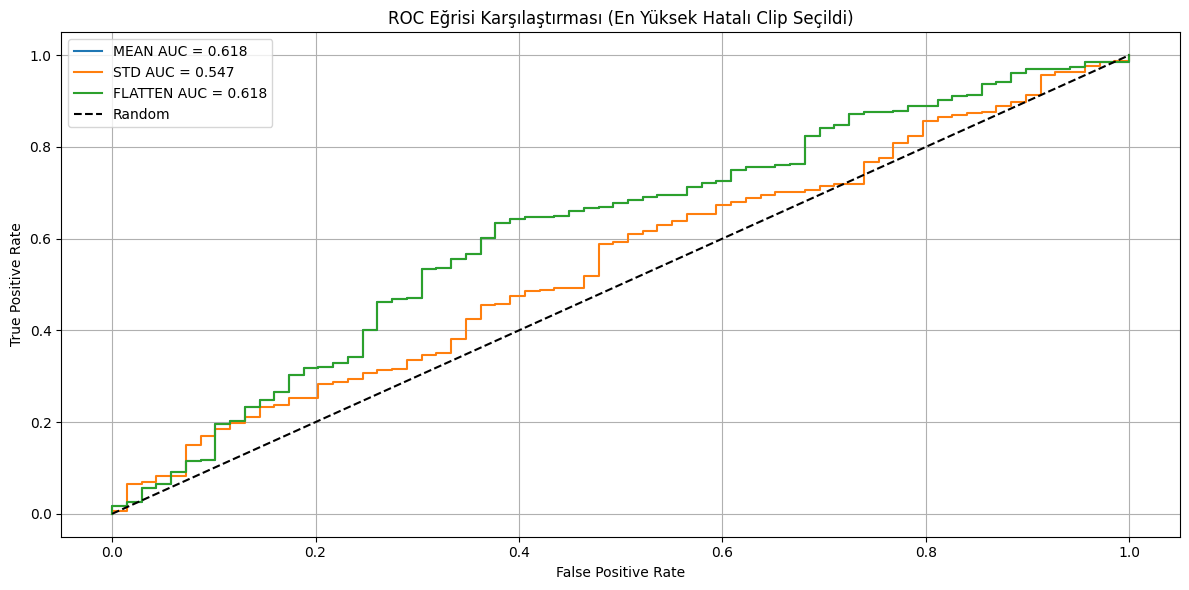

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- CSV'yi oku ---
csv_path = "/content/drive/MyDrive/modelepochsaves/autoencoder_features3d_batched.csv"
errors_df = pd.read_csv(csv_path)

# --- Etiketleri ekle ---
errors_df['filename'] = errors_df['video_path'].map(os.path.basename)
meta_df = balanced_df[['video_path', 'binary_label']].drop_duplicates()
meta_df['filename'] = meta_df['video_path'].map(os.path.basename)

# --- En yüksek recon_error'a sahip clip'i seç ---
idx_max = errors_df.groupby('video_path')['recon_error'].idxmax()
agg_df = errors_df.loc[idx_max].reset_index(drop=True)

# --- Etiketle eşleştir ---
merged = agg_df.merge(meta_df[['video_path', 'binary_label']], on='video_path')

# --- Feature extraction yöntemleri ---
methods = {
    "mean": lambda x: x.mean(axis=1),
    "std": lambda x: x.std(axis=1),
    "flatten": lambda x: x  # tüm 128 feature + recon_error
}

# --- Plot setup ---
plt.figure(figsize=(12, 6))

for i, (name, func) in enumerate(methods.items(), 1):
    feature_cols = [c for c in merged.columns if c.startswith("feat_")]
    X_feats = merged[feature_cols].values
    X_proc = func(X_feats)

    y_true = merged['binary_label'].astype(int).values

    if name == "flatten":
        all_feats = np.hstack([X_proc, merged['recon_error'].values.reshape(-1, 1)])
        y_score = all_feats.mean(axis=1)  # her sample için tek skor
    else:
        X_proc = X_proc.reshape(-1, 1)
        y_score = X_proc.ravel()

    fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name.upper()} AUC = {roc_auc:.3f}")

# --- Random baseline ---
plt.plot([0, 1], [0, 1], 'k--', label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi Karşılaştırması (En Yüksek Hatalı Clip Seçildi)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
merged['binary_label'].value_counts()


,count
binary_label,
1,434
0,69


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import os

# --- CSV'yi oku ---
csv_path = "/content/drive/MyDrive/modelepochsaves/autoencoder_features3d_batched.csv"
df = pd.read_csv(csv_path)

# --- Etiketleri eşleştir ---
df['filename'] = df['video_path'].map(os.path.basename)
meta_df = balanced_df[['video_path', 'binary_label']].drop_duplicates()
meta_df['filename'] = meta_df['video_path'].map(os.path.basename)
df = df.merge(meta_df[['filename', 'binary_label']], on='filename', how='left')
df = df.dropna(subset=['binary_label'])

# --- ✅ En yüksek hatalı clip'i seç ---
idx_max_error = df.groupby('video_path')['recon_error'].idxmax()
df = df.loc[idx_max_error].reset_index(drop=True)

# --- Özellik kolonları ---
feature_cols = [col for col in df.columns if col.startswith("feat_")] + ['recon_error']
X = df[feature_cols].values
y = df['binary_label'].astype(int).values

# --- Eğitim ve test bölmesi ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# --- XGBoost modeli ---
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# --- Değerlendirme ---
y_pred_prob = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)
auc_score = roc_auc_score(y_val, y_pred_prob)

print(f"✅ AUC (Sadece En Yüksek Hatalı Clip ile): {auc_score:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:53:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ AUC (Sadece En Yüksek Hatalı Clip ile): 0.8235

Confusion Matrix:
 [[  4  13]
 [  1 120]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.24      0.36        17
           1       0.90      0.99      0.94       121

    accuracy                           0.90       138
   macro avg       0.85      0.61      0.65       138
weighted avg       0.89      0.90      0.87       138



In [ ]:
#Augmentation
import torch
import torchvision.transforms as T


frame_transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=(-10, 10)),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    T.RandomApply([T.GaussianBlur(3)], p=0.3),
    T.RandomApply([T.RandomGrayscale(p=0.2)], p=0.2),
])


def frame_dropout(frames, p=0.2):
    """Belirli bir ihtimalle rastgele kareleri düşür."""
    keep_mask = torch.rand(len(frames)) > p
    return frames[keep_mask] if keep_mask.sum() > 0 else frames

def speed_perturbation(frames, min_speed=0.8, max_speed=1.2):
    """Videoyu rastgele hızlandır veya yavaşlat."""
    speed_factor = torch.FloatTensor(1).uniform_(min_speed, max_speed).item()
    indices = torch.linspace(0, len(frames)-1, int(len(frames) * speed_factor)).long()
    return frames[indices]

#Fixes frame count after applying frame dropout at augmentation

def fix_frame_count(frames, target_num_frames):
    """Frame sayısını sabitler: Eğer fazla ise kırpar, eksikse tekrarlar."""
    num_frames = frames.shape[0]  # Frame sayısını al

    if num_frames > target_num_frames:
        frames = frames[:target_num_frames]  # Fazla olanları kırp
    elif num_frames < target_num_frames:
        repeat_frames = target_num_frames - num_frames
        last_frame = frames[-1].unsqueeze(0).repeat(repeat_frames, 1, 1, 1)  # Eksik frame'leri tekrar et
        frames = torch.cat([frames, last_frame], dim=0)

    return frames  # Her durumda (T, C, H, W) döner

In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset
import torchvision
import torch.nn.functional as F
import pandas as pd

# Yukarıda tanımlı augmentasyon fonksiyonları ve frame_transform kullanılıyor:
# frame_dropout, speed_perturbation, fix_frame_count, frame_transform

class VideoDataset(Dataset):
    def __init__(
        self,
        metadata_df: pd.DataFrame,
        ae_features_csv: str,
        num_frames: int = 8,
        resize_size=(192, 192),
        mode: str = "train"
    ):
        """
        metadata_df: DataFrame with columns ['video_path','binary_label','multi_label']
        ae_features_csv: CSV with ['video_path','recon_error'] per frame index
        """
        self.meta = metadata_df.reset_index(drop=True)
        self.ae_data = pd.read_csv(ae_features_csv)
        self.num_frames = num_frames
        self.resize_size = resize_size
        self.mode = mode

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        video_path = row['video_path']
        binary_label = int(row['binary_label'])
        multi_label = int(row['multi_label'])
        augment_flag = bool(row.get('augment', False))  # <— augment bayrağı

        # Segment başlangıcını belirle (AE hatalarına göre)
        vid_err = self.ae_data[self.ae_data['video_path'] == video_path]['recon_error'].values
        total_err = len(vid_err)
        if binary_label == 1:
            # Anormal: sliding window ile en yüksek hata segmentini seç
            if total_err < self.num_frames:
                start_idx = 0
            else:
                means = pd.Series(vid_err).rolling(self.num_frames).mean().dropna().values
                start_idx = int(means.argmax())
        else:
            # Normal: rastgele başlangıç
            if total_err <= self.num_frames:
                start_idx = 0
            else:
                start_idx = random.randint(0, total_err - self.num_frames)

        # Kareleri oku
        frames = []
        vr = torchvision.io.VideoReader(video_path, 'video')
        vr.set_current_stream('video')
        for i, frm in enumerate(vr):
            if i < start_idx:
                continue
            if len(frames) >= self.num_frames:
                break
            img = frm['data'].float() / 255.0  # (C,H,W)
            img = F.interpolate(
                img.unsqueeze(0), size=self.resize_size,
                mode='bilinear', align_corners=False
            ).squeeze(0)
            frames.append(img)
        # Eksikse son kareyi tekrar et
        while len(frames) < self.num_frames:
            frames.append(frames[-1].clone())

        # Augmentasyon (sadece eğitim için)
        clip = torch.stack(frames)  # (T, C, H, W)
        if self.mode == 'train':
            # 1) Eğer bu bir anormal örnekse, her zaman augment et
            # 2) Eğer bu normal ama oversample edilmişse (augment_flag==True), augment et
            if binary_label == 1 or augment_flag:
                clip = frame_dropout(clip, p=0.2)
                clip = speed_perturbation(clip, min_speed=0.8, max_speed=1.2)
                clip = fix_frame_count(clip, self.num_frames)
                clip = torch.stack([frame_transform(f) for f in clip])
            else:
                # normal gerçek örnekler için dilersen hafif normalize/crop falan yap
                clip = torch.stack([frame_transform(f) for f in clip])

        # Son düzenleme: (C, T, H, W)
        clip = clip.permute(1, 0, 2, 3).contiguous()

        return (
            clip,
            torch.tensor(binary_label, dtype=torch.float32),
            torch.tensor(multi_label, dtype=torch.long)
        )

In [ ]:
train_dataset = VideoDataset(train_df, "/content/drive/MyDrive/modelepochsaves/autoencoder_features_batched.csv", num_frames=48, mode="train")
test_dataset = VideoDataset(test_df, "/content/drive/MyDrive/modelepochsaves/autoencoder_features_batched.csv", num_frames=48, mode="test")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train loader {len(train_loader)} batches")
print(f"Test loader {len(test_loader)} batches")

Train loader 326 batches
Test loader 82 batches


In [ ]:
#Tensor format kontrolü

batch_clip, batch_bin, batch_multi = next(iter(train_loader))
print("Batch clip shape:", batch_clip.shape)
# Beklenen: (4, C, T, H, W)

print("Binary labels shape:", batch_bin.shape)      # (4,)
print("Multi labels shape:", batch_multi.shape)    # (4,)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# ✅ X3D Modelini Yükleme
model_name = "x3d_s"
base_model = torch.hub.load('facebookresearch/pytorchvideo', model_name, pretrained=True)

# ✅ **Çıkış Katmanlarını Güncelle**
in_features = base_model.blocks[-1].proj.out_features  # ✅ **Doğru çıkışı al!** (400 olmalı)

binary_head = nn.Linear(2048, 1)  # Binary sınıflandırma için Sigmoid
multi_head = nn.Linear(2048, len(train_df["multi_label"].unique()))  # Multi-class sınıflandırma

# ✅ **MultiTaskX3D Modeli**
class MultiTaskX3D(nn.Module):
    def __init__(self, base_model, binary_head, multi_head):
        super(MultiTaskX3D, self).__init__()

        # **Feature Extractor - Son bloğun içindeki ProjectedPool eklendi!**
        self.feature_extractor = nn.Sequential(
            *base_model.blocks[:-1],
            base_model.blocks[-1].pool  # ✅ **Burada 400'e dönüşüm sağlandı!**
        )

        # **Global Average Pooling - Tüm boyutları 1x1x1'e düşürüyor!**
        self.gap = nn.AdaptiveAvgPool3d(1)

        # **Flatten**
        self.flatten = nn.Flatten()

        # **Çıkış Katmanları**
        self.binary_head = binary_head
        self.binary_activation = nn.Sigmoid()

        self.multi_head = multi_head
        self.multi_activation = nn.Softmax(dim=1)

    def forward(self, x):
        #print(f"🚀 Model Girişi: {x.shape}")

        x = self.feature_extractor(x)
        #print(f"🟡 Feature Extractor Çıkışı: {x.shape}")  # **(16, 400, 1, 1, 1) olmalı!**

        x = self.gap(x)  # ✅ **GAP ile (16, 400, 1, 1, 1)**
        #print(f"🔵 GAP Sonrası Boyut: {x.shape}")

        x = self.flatten(x)  # ✅ **Artık (16, 400) olması lazım!**
        #print(f"🟢 Flatten Sonrası Boyut: {x.shape}")

        binary_out = self.binary_head(x)  # Binary sınıflandırma
        multi_out = self.multi_activation(self.multi_head(x))  # Multi-class sınıflandırma

        return binary_out, multi_out

# ✅ Modeli başlat
model = MultiTaskX3D(base_model, binary_head, multi_head)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"🚀 Model başarıyla yüklendi! Çalıştırılan cihaz: {device}")

Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/X3D_S.pyth" to /root/.cache/torch/hub/checkpoints/X3D_S.pyth
100%|██████████| 29.4M/29.4M [00:00<00:00, 58.6MB/s]


🚀 Model başarıyla yüklendi! Çalıştırılan cihaz: cuda


import torch

model = model.to("cpu")
dummy_input = torch.randn(1, 3, 16, 160, 160)

torch.onnx.export(model, dummy_input, "x3d_xs.onnx", opset_version=11
                  ,do_constant_folding=True, input_names=["input"], output_names=["output"])

In [ ]:
from torch.nn import CrossEntropyLoss

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self,inputs,targets):
        ce_loss = F.cross_entropy(inputs,targets,reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

# ─── Ayarlar & Çıktı dizini ─────────────────────────────────────────────────
epoch_file_location = "/content/drive/MyDrive/modelepochsaves/modelepochsavesx3d"
os.makedirs(epoch_file_location, exist_ok=True)

# ─── Model, Loss, Optimizer, Scheduler ─────────────────────────────────────
criterion_binary = nn.BCEWithLogitsLoss()
criterion_multi  = FocalLoss()
optimizer        = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler        = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler           = torch.amp.GradScaler()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ─── Resume Ayarları ─────────────────────────────────────────────────────────
# Eğer belirli bir epoch'tan devam etmek isterseniz, o epoch numarasını buraya koyun.
# Örneğin 13. epoch'tan devam:
resume_epoch = 0
max_epochs    = 100
best_loss     = float('inf')
counter       = 0

# Checkpoint dosya yolunu oluştur
ckpt_path = os.path.join(epoch_file_location, f"model_epoch_{resume_epoch}.pth")
if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path)
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    best_loss = ckpt.get('best_loss', best_loss)
    counter   = ckpt.get('counter', counter)
    start_epoch = ckpt['epoch'] + 1
    print(f"✅ Loaded checkpoint from epoch {ckpt['epoch']}")
else:
    start_epoch = 1
    print("⚠️ No checkpoint found, starting from scratch.")

# ─── Early Stopping Parametreleri ────────────────────────────────────────────
patience           = 5
min_delta          = 0.01
accuracy_threshold = 85.0

# ─── Eğitim & Doğrulama Döngüsü ───────────────────────────────────────────────
for epoch in range(start_epoch, max_epochs+1):
    # --- Eğitim ---
    model.train()
    train_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{max_epochs} ▶ Train", leave=False)
    for videos, binary_labels, multi_labels in train_bar:
        videos        = videos.to(device)
        binary_labels = binary_labels.to(device).float()
        multi_labels  = multi_labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type=device.type):
            binary_out, multi_out = model(videos)
            bin_loss = criterion_binary(binary_out.squeeze(), binary_labels)
            mask     = (binary_labels == 1)
            mul_loss = criterion_multi(multi_out[mask], multi_labels[mask]) if mask.sum()>0 else torch.tensor(0.0, device=device)
            loss     = bin_loss + mul_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
        train_bar.set_postfix(loss=f"{train_loss/(train_bar.n+1):.4f}")
    train_loss /= len(train_loader)

    # --- Doğrulama ---
    model.eval()
    val_loss       = 0.0
    correct_binary = correct_multi = total_binary = total_multi = 0
    val_bar = tqdm(test_loader, desc=f"Epoch {epoch}/{max_epochs} ◀ Val", leave=False)
    with torch.no_grad():
        for videos, binary_labels, multi_labels in val_bar:
            videos        = videos.to(device)
            binary_labels = binary_labels.to(device).float()
            multi_labels  = multi_labels.to(device)

            binary_out, multi_out = model(videos)
            pred_bin = (binary_out.squeeze()>0.5).long()
            correct_binary += (pred_bin==binary_labels).sum().item()
            total_binary   += binary_labels.size(0)

            mask = (binary_labels==1)
            if mask.sum()>0:
                pred_mul = torch.argmax(multi_out[mask], dim=1)
                correct_multi += (pred_mul==multi_labels[mask]).sum().item()
                total_multi   += mask.sum().item()

            vloss = criterion_binary(binary_out.squeeze(), binary_labels)
            if mask.sum()>0:
                vloss += criterion_multi(multi_out[mask], multi_labels[mask])
            val_loss += vloss.item()
            val_bar.set_postfix(val_loss=f"{val_loss/(val_bar.n+1):.4f}")
    val_loss /= len(test_loader)

    bin_acc = 100 * correct_binary / total_binary
    mul_acc = 100 * correct_multi  / total_multi if total_multi>0 else 0.0

    # --- Epoch Özeti & Checkpoint Kaydetme ---
    print(f"Epoch {epoch}/{max_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
          f"| Binary Acc: {bin_acc:.2f}% | Multi Acc: {mul_acc:.2f}%")

    # Tam checkpoint
    save_path = os.path.join(epoch_file_location, f"model_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict':     model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_loss':            best_loss,
        'counter':              counter
    }, save_path)

    # --- Early Stopping ---
    if bin_acc >= accuracy_threshold:
        if best_loss - val_loss > min_delta:
            best_loss = val_loss; counter = 0
        else:
            counter += 1
            print(f"❗ Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("⏹️ Early stopping triggered.")
            break
    else:
        print(f"🚨 Binary Acc {bin_acc:.2f}% < {accuracy_threshold}%, early stopping pasif.")

    # Scheduler adımı, val_loss yerine epoch tabanlı CosineAnnealingLR için
    scheduler.step()

print("✅ Eğitim tamamlandı!")


⚠️ No checkpoint found, starting from scratch.


Epoch 1/100 ▶ Train:   0%|          | 0/326 [00:00<?, ?it/s]